In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import medmnist
from medmnist import INFO, Evaluator

## PART B: LOGISTIC REGRESSION ON BREAST MNIST

### DATA LOADING AND INSPECTION

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

### LOGISTIC REGRESSION

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validate_dataset=DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /home/xela/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/xela/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/xela/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/xela/.medmnist/pathmnist.npz


In [5]:
print("=======TRAIN DATASET============")
print(train_dataset)
print("=======VALIDATE DATASET============")
print(validate_dataset)
print("=======TEST DATASET============")
print(test_dataset)


=======TRAIN DATASET============
Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /home/xela/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28

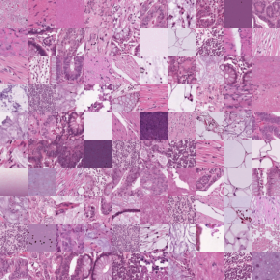

In [6]:
# visualization

train_dataset.montage(length=10)



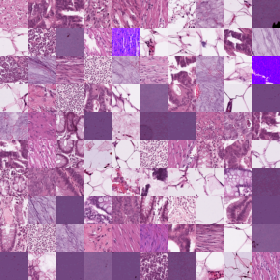

In [7]:
test_dataset.montage(length=10)

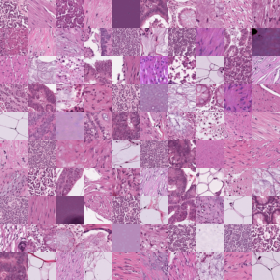

In [8]:
validate_dataset.montage(length=10)

## PART C: CONVOLUSION NEURAL NETWORKS ON OCTMNIST

In [9]:
#define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [10]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


In [11]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  acc: %.3f  auc:%.3f' % (split, *metrics))

        
#print('==> Evaluating ...')
test('train')
test('test')

train  acc: 0.987  auc:0.846
test  acc: 0.966  auc:0.779


## PART D: UNSUPEVISED LEARNING

### DIMENSIONALITY REDUCTION AND CLUSTERING

In [28]:
#Loading the training and test sets from Fashion MNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [29]:
#Extracting 2 classes from the MNIST dataset
idx = (train_set.targets==7) | (train_set.targets==2) 
train_set.targets = train_set.targets[idx]
train_set.data = train_set.data[idx]

idx_1 = (test_set.targets==7) | (test_set.targets==2) 
test_set.targets = test_set.targets[idx_1]
test_set.data = test_set.data[idx_1]

In [30]:
#Splitting the train_set to train and cross validation set
indices = list(range(len(train_set)))

#Shuffling the indices to get a random split
np.random.shuffle(indices)

#Getting the 20% split
split = int(np.floor(0.2* len(train_set)))

train_sample = SubsetRandomSampler(indices[:split]) 
validation_sample = SubsetRandomSampler(indices[split:]) 

#Data Loader
trainloader = torch.utils.data.DataLoader(train_set, sampler = train_sample, batch_size = 64)
validloader = torch.utils.data.DataLoader(train_set, sampler = validation_sample, batch_size = 64)
testloader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)

In [31]:
trainset_arr = next(iter(train_loader))[0].numpy()
testset_arr = next(iter(test_loader))[0].numpy()
trainset_arr = trainset_arr.reshape(384,784)
testset_arr = testset_arr.reshape(768,784)

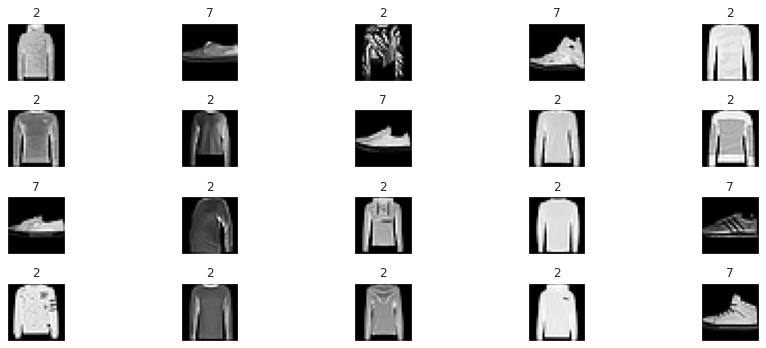

In [32]:
#Visualizing the dataset
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()

fig = plt.figure(figsize = (15,5))

for ix in np.arange(20):
    ax = fig.add_subplot(4, 5, ix + 1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[ix]), cmap = 'gray')
    ax.set_title(labels[ix].item())
    fig.tight_layout()

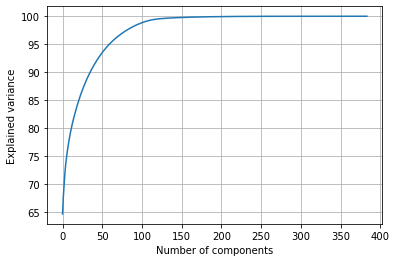

In [17]:
#Applying PCA to our dataset
from sklearn.decomposition import PCA

pca_384 = PCA(n_components=384)
pca_384.fit(trainset_arr)

plt.grid()
plt.plot(np.cumsum(pca_384.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

In [18]:
#Printing the eigenvectors
print(pca_384.components_)
print(pca_384.explained_variance_)
print(pca_384.singular_values_)


[[-0.03492709 -0.03639764 -0.03819862 ... -0.03786884 -0.03629168
  -0.03614004]
 [-0.0205639  -0.0166242  -0.01094609 ... -0.08149793 -0.06669141
  -0.05214559]
 [ 0.02465221  0.01876016  0.01902068 ... -0.02005413 -0.00451076
  -0.00381694]
 ...
 [ 0.00888696 -0.05250742 -0.07472856 ...  0.00208637 -0.00145422
  -0.03504951]
 [ 0.06660044 -0.04472683  0.04034457 ... -0.01211868 -0.01034949
   0.02855886]
 [-0.0150358   0.01429524  0.03963871 ... -0.0319663  -0.01359474
  -0.00350751]]
[5.68990898e+01 2.72099710e+00 1.95868146e+00 1.80508482e+00
 1.38777936e+00 1.07045722e+00 9.19850171e-01 8.62567782e-01
 7.49002099e-01 7.24440873e-01 6.44999146e-01 6.13310754e-01
 5.72890580e-01 5.33017457e-01 4.95454162e-01 4.78979439e-01
 4.61116612e-01 4.52050000e-01 4.39585388e-01 4.12571967e-01
 3.97777945e-01 3.88062865e-01 3.77349049e-01 3.66603523e-01
 3.41371268e-01 3.34428310e-01 3.29942435e-01 3.15316051e-01
 3.04918587e-01 2.97668248e-01 2.89451867e-01 2.84974039e-01
 2.71535575e-01 2.60

In [ ]:
# Visualise the two-dimensional PCA representations of all data points in a 2D plane

Text(0, 0.5, 'Height')

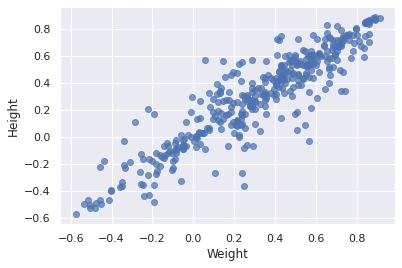

In [43]:
import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.datasets import make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
sns.set()
    
X = trainset_arr

plt.scatter(X[:,0], X[:,1], alpha=0.7, edgecolors='b')
plt.xlabel('Weight')
plt.ylabel('Height')

#Use spectral clustering to cluster all data points as represented by the top two PCs

In [21]:
W = pairwise_distances(X, metric="euclidean")
vectorizer = np.vectorize(lambda x: 1 if x < 5 else 0)
W = np.vectorize(vectorizer)(W)
print(W)

[[1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]]


In [22]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    

[[0 0 1 1 1 0 0 1 0 1]
 [0 0 1 1 0 1 1 0 1 1]
 [1 1 0 1 0 1 0 1 0 1]
 [1 1 1 0 1 0 1 1 1 0]
 [1 0 0 1 0 1 0 0 0 1]
 [0 1 1 0 1 0 0 0 1 1]
 [0 1 0 1 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 1 1]
 [0 1 0 1 0 1 0 1 0 1]
 [1 1 1 0 1 1 0 1 1 0]]


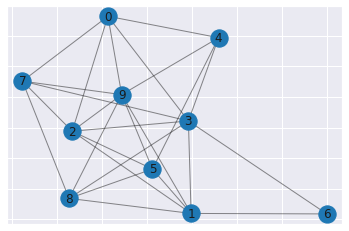

In [23]:
G = nx.random_graphs.erdos_renyi_graph(10, 0.5)
draw_graph(G)
W = nx.adjacency_matrix(G)
print(W.todense())

In [24]:
# degree matrix
D = np.diag(np.sum(np.array(W.todense()), axis=1))
print('degree matrix:')
print(D)
# laplacian matrix
L = D - W
print('laplacian matrix:')
print(L)


degree matrix:
[[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 7]]
laplacian matrix:
[[ 5  0 -1 -1 -1  0  0 -1  0 -1]
 [ 0  6 -1 -1  0 -1 -1  0 -1 -1]
 [-1 -1  6 -1  0 -1  0 -1  0 -1]
 [-1 -1 -1  7 -1  0 -1 -1 -1  0]
 [-1  0  0 -1  4 -1  0  0  0 -1]
 [ 0 -1 -1  0 -1  5  0  0 -1 -1]
 [ 0 -1  0 -1  0  0  2  0  0  0]
 [-1  0 -1 -1  0  0  0  5 -1 -1]
 [ 0 -1  0 -1  0 -1  0 -1  5 -1]
 [-1 -1 -1  0 -1 -1  0 -1 -1  7]]


In [25]:
e, v = np.linalg.eig(L)
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[-0.000 1.830 9.036 3.734 3.966 5.314 7.861 6.325 6.637 7.297]
eigenvectors:
[[0.316 -0.184 -0.143 0.306 -0.453 0.191 0.179 -0.322 0.610 -0.054]
 [0.316 0.105 -0.254 -0.251 0.223 0.209 0.472 -0.457 -0.312 0.374]
 [0.316 -0.117 -0.248 -0.122 -0.139 0.554 -0.583 0.017 -0.312 -0.216]
 [0.316 0.049 0.636 0.034 -0.152 -0.127 0.148 -0.292 -0.331 -0.486]
 [0.316 -0.201 -0.229 0.733 0.291 -0.309 -0.079 0.054 -0.277 0.060]
 [0.316 -0.146 0.097 -0.108 0.568 0.285 0.284 0.418 0.310 -0.319]
 [0.316 0.905 -0.054 0.125 -0.036 -0.025 -0.106 0.173 0.139 0.021]
 [0.316 -0.159 -0.145 -0.220 -0.514 -0.235 0.306 0.577 -0.220 0.105]
 [0.316 -0.097 -0.222 -0.460 0.165 -0.601 -0.316 -0.239 0.251 -0.145]
 [0.316 -0.155 0.561 -0.037 0.047 0.057 -0.304 0.071 0.141 0.661]]


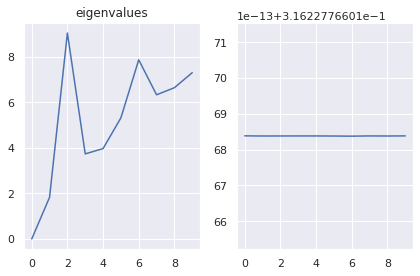

In [26]:
fig = plt.figure()
ax1 = plt.subplot(121)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 10e-6)[0]
ax2 = plt.subplot(122)
plt.plot(v[:, i[0]])
fig.tight_layout()
plt.show()

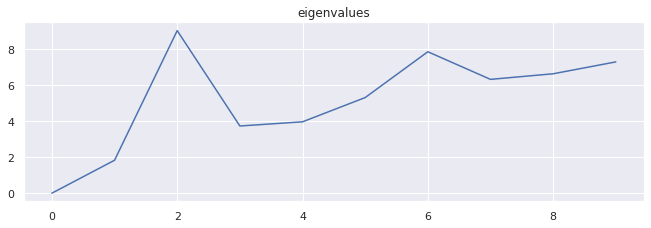

In [41]:
fig = plt.figure(figsize=[18, 6])
ax1 = plt.subplot(221)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 0.5)[0]
fig.tight_layout()

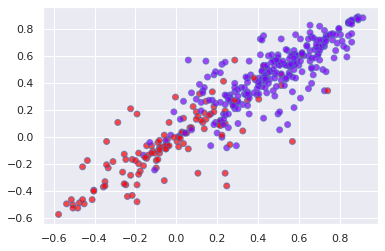

In [44]:
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(X)
plt.scatter(X[:,0], X[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')